In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from keras.layers import Input, Embedding, multiply, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 10

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
df = pd.read_csv('../input/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.isnull().sum().any()
df = df.drop('Time',axis=1)
X = df.drop('Class',axis=1).values 
y = df['Class'].values

In [7]:
X -= X.min(axis=0)
X /= X.max(axis=0)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.1)

In [9]:
def build_generator(latent_dim,data_dim):

        model = Sequential()

        model.add(Dense(16, input_dim=latent_dim))
    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(32, input_dim=latent_dim))
    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(data_dim,activation='tanh'))

        model.summary()

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

In [10]:
generator = build_generator(latent_dim=10,data_dim=29)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                176       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 29)                957       
Total para

In [11]:
def build_discriminator(data_dim,num_classes):
    model = Sequential()
    model.add(Dense(31,input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.25))
    model.add(Dense(16,input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    
    model.summary()
    img = Input(shape=(data_dim,))
    features = model(img)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(num_classes+1, activation="softmax")(features)
    return Model(img, [valid, label])

In [12]:
discriminator = build_discriminator(data_dim=29,num_classes=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 31)                930       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 31)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 31)                124       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16)                0         
Total params: 1,566
Trainable params: 1,504
Non-trainable params: 62
_________________________________________________________________


In [13]:
optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss=['binary_crossentropy', 'categorical_crossentropy'],
    loss_weights=[0.5, 0.5],
    optimizer=optimizer,
    metrics=['accuracy'])

In [14]:
noise = Input(shape=(10,))
img = generator(noise)
discriminator.trainable = False
valid,_ = discriminator(img)
combined = Model(noise , valid)
combined.compile(loss=['binary_crossentropy'],
    optimizer=optimizer)

In [15]:
rus = RandomUnderSampler(random_state=42)

In [16]:
X_res, y_res = rus.fit_sample(X, y)

In [17]:
X_res -= X_res.min()
X_res /= X_res.max()

In [18]:
X_test -= X_test.min()
X_test /= X_test.max()

In [19]:
X_test_res, y_test_res = rus.fit_sample(X_test,y_test)

In [20]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [21]:
def train(X_train,y_train,
          X_test,y_test,
          generator,discriminator,
          combined,
          num_classes,
          epochs, 
          batch_size=128):
    
    f1_progress = []
    d_loss_progress = []
    half_batch = int(batch_size / 2)

    noise_until = epochs

    # Class weights:
    # To balance the difference in occurences of digit class labels.
    # 50% of labels that the discriminator trains on are 'fake'.
    # Weight = 1 / frequency
    cw1 = {0: 1, 1: 1}
    cw2 = {i: num_classes / half_batch for i in range(num_classes)}
    cw2[num_classes] = 1 / half_batch 
    d_loss_sum = 0

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, 10))
        gen_imgs = generator.predict(noise)

        valid = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))

        labels = to_categorical(y_train[idx], num_classes=num_classes+1)
        fake_labels = to_categorical(np.full((half_batch, 1), num_classes), num_classes=num_classes+1)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 10))
        validity = np.ones((batch_size, 1))

        # Train the generator
        g_loss = combined.train_on_batch(noise, validity, class_weight=[cw1, cw2])

        # Plot the progress
        print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))
        d_loss_sum += 100*d_loss[3]
        
        if epoch % 10 == 0:
            _,y_pred = discriminator.predict(X_test,batch_size=batch_size)
            #print(y_pred.shape)
            y_pred = np.argmax(y_pred[:,:-1],axis=1)
            
            f1 = f1_score(y_test,y_pred)
            print('Epoch: {}, F1: {:.5f}, F1P: {}'.format(epoch,f1,len(f1_progress)))
            cm = confusion_matrix(y_test, y_pred)

            print(cm)
            print(d_loss_sum/10)
            d_loss_progress.append(d_loss_sum/10)
            f1_progress.append(f1)
            d_loss_sum = 0
    
    return f1_progress, d_loss_progress

In [22]:
f1_p, d_l_p = train(X_res,y_res,
             X_test,y_test,
             generator,discriminator,
             combined,
             num_classes=2,
             epochs=2000, 
             batch_size=128)

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


0 [D loss: 0.451055, acc: 45.31%, op_acc: 24.22%] [G loss: 0.593363]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 0, F1: 0.00000, F1P: 0
[[28432     0]
 [   49     0]]
4.53125
1 [D loss: 0.442756, acc: 46.09%, op_acc: 25.78%] [G loss: 0.603959]
2 [D loss: 0.451729, acc: 50.78%, op_acc: 32.03%] [G loss: 0.634167]
3 [D loss: 0.460006, acc: 50.00%, op_acc: 26.56%] [G loss: 0.648444]
4 [D loss: 0.444264, acc: 45.31%, op_acc: 26.56%] [G loss: 0.608890]
5 [D loss: 0.458245, acc: 48.44%, op_acc: 28.91%] [G loss: 0.572532]
6 [D loss: 0.435555, acc: 50.00%, op_acc: 19.53%] [G loss: 0.622673]
7 [D loss: 0.411423, acc: 48.44%, op_acc: 25.00%] [G loss: 0.608667]
8 [D loss: 0.459988, acc: 43.75%, op_acc: 31.25%] [G loss: 0.637255]
9 [D loss: 0.445127, acc: 49.22%, op_acc: 26.56%] [G loss: 0.633556]
10 [D loss: 0.436110, acc: 46.09%, op_acc: 23.44%] [G loss: 0.591626]
Epoch: 10, F1: 0.00000, F1P: 1
[[28432     0]
 [   49     0]]
47.8125
11 [D loss: 0.460545, acc: 46.09%, op_acc: 28.12%] [G loss: 0.599877]
12 [D loss: 0.439558, acc: 46.88%, op_acc: 33.59%] [G loss: 0.627461]
13 [D loss: 0.436180, acc: 50.

Text(0,0.5,'F1 Score Validation')

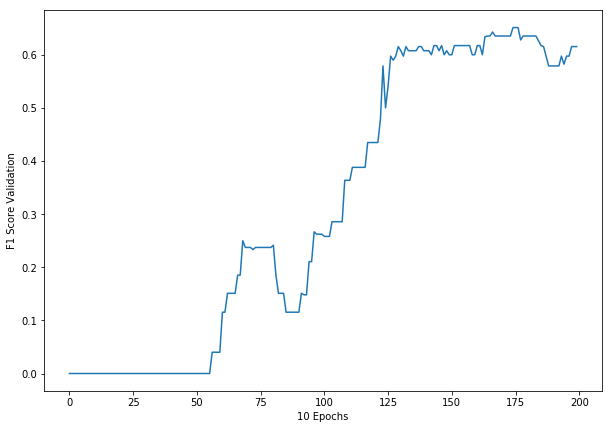

In [23]:
fig = plt.figure(figsize=(10,7))
plt.plot(f1_p)
plt.xlabel('10 Epochs')
plt.ylabel('F1 Score Validation')

Text(0,0.5,'Accuracy')

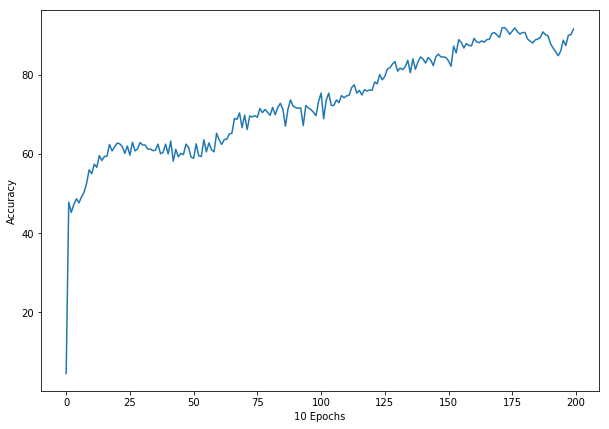

In [24]:
fig = plt.figure(figsize=(10,7))
plt.plot(d_l_p)
plt.xlabel('10 Epochs')
plt.ylabel('Accuracy')

In [25]:
print(d_l_p[-1])

91.5625
